In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torchsummary
from torchsummary import summary
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

### For Reproducablity

In [0]:
SEED = 1

#If cuda is available

use_cuda = torch.cuda.is_available()
# For reproducibility
torch.manual_seed(SEED)

if use_cuda:
    torch.cuda.manual_seed(SEED)

### Select the device to use

In [3]:

device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


### Data Transformations
We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [0]:
torch.manual_seed(1)
batch_size = 128


# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=8, pin_memory=True) if use_cuda else dict(shuffle=True, batch_size=64)

train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True, transform=train_transforms),
                                            **dataloader_args)

test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False, download=True, transform=test_transforms),
                                          **dataloader_args)

### Define the Model

In [0]:
dropout_value = 0.2

OP_CH_CONV_BLK1  = 16
OP_CH_CONV_BLK2  = 12
OP_CH_CONV_BLK21 = 32
OP_CH_CONV_BLK3  = 12
OP_CH_CONV_BLK4  = 12
OP_CH_CONV_BLK5  = 12
OP_CH_CONV_BLK6  = 12
OP_CH_CONV_BLK7  = 12
OP_CH_CONV_BLK71 = 32
OP_NODES = 10


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=OP_CH_CONV_BLK1, kernel_size=(3, 3), padding=0, bias=False),
                                        nn.ReLU(),
                                        nn.Dropout(dropout_value),
                                        nn.BatchNorm2d(OP_CH_CONV_BLK1)
                                        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(nn.Conv2d(in_channels=OP_CH_CONV_BLK1, out_channels=OP_CH_CONV_BLK2, kernel_size=(3, 3), padding=0, bias=False),
                                        nn.ReLU(),
                                        nn.Dropout(dropout_value),
                                        nn.BatchNorm2d(OP_CH_CONV_BLK2)
                                        ) # output_size = 24


        self.convblock21 = nn.Sequential(
                                        nn.Conv2d(in_channels=OP_CH_CONV_BLK2, out_channels=OP_CH_CONV_BLK21, kernel_size=(1, 1), padding=0, bias=False),
                                        nn.ReLU(),
                                        nn.Dropout(dropout_value),
                                        nn.BatchNorm2d(OP_CH_CONV_BLK21)
                                        ) # output_size = 22
        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        self.convblock3 = nn.Sequential(
                                        nn.Conv2d(in_channels=OP_CH_CONV_BLK21, out_channels=OP_CH_CONV_BLK3, kernel_size=(3, 3), padding=0, bias=False),
                                        nn.ReLU(),
                                        nn.Dropout(dropout_value),
                                        nn.BatchNorm2d(OP_CH_CONV_BLK3)
                                        ) # output_size = 10


        self.convblock4 = nn.Sequential(
                                        nn.Conv2d(in_channels=OP_CH_CONV_BLK3, out_channels=OP_CH_CONV_BLK4, kernel_size=(1, 1), padding=0, bias=False),
                                        nn.ReLU(),
                                        nn.Dropout(dropout_value),
                                        nn.BatchNorm2d(OP_CH_CONV_BLK4)
                                        ) # output_size = 8


        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
                                        nn.Conv2d(in_channels=OP_CH_CONV_BLK4, out_channels=OP_CH_CONV_BLK5, kernel_size=(3, 3), padding=0, bias=False),
                                        nn.ReLU(),
                                        nn.Dropout(dropout_value),
                                        nn.BatchNorm2d(OP_CH_CONV_BLK5)
                                        ) # output_size = 6

        self.convblock6 = nn.Sequential(
                                        nn.Conv2d(in_channels=OP_CH_CONV_BLK5, out_channels=OP_CH_CONV_BLK6, kernel_size=(3, 3), padding=0, bias=False),
                                        nn.ReLU(),
                                        nn.Dropout(dropout_value),
                                        nn.BatchNorm2d(OP_CH_CONV_BLK6)
                                        ) # output_size = 4

        self.convblock7 = nn.Sequential(
                                          nn.Conv2d(in_channels=OP_CH_CONV_BLK6, out_channels=OP_CH_CONV_BLK7, kernel_size=(3, 3), padding=0, bias=False),
                                          nn.ReLU(),
                                          nn.Dropout(dropout_value),
                                          nn.BatchNorm2d(OP_CH_CONV_BLK7)
                                          ) # output_size = 2

        self.convblock71 = nn.Sequential(
                                          nn.Conv2d(in_channels=OP_CH_CONV_BLK7, out_channels=OP_CH_CONV_BLK71, kernel_size=(1, 1), padding=0, bias=False),
                                          nn.ReLU(),
                                          nn.Dropout(dropout_value),
                                          nn.BatchNorm2d(OP_CH_CONV_BLK71)
                                          ) # output_size = 2
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
                                  nn.AvgPool2d(kernel_size=4),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(OP_CH_CONV_BLK71),
                                  #nn.Dropout(dropout_value)
                                  ) # output_size = 1

        self.convblock8 = nn.Sequential(
                                        nn.Conv2d(in_channels=OP_CH_CONV_BLK71, out_channels=OP_NODES, kernel_size=(1, 1), padding=0, bias=False),
                                        # nn.BatchNorm2d(10), NEVER
                                        # nn.ReLU() NEVER!
                                        ) # output_size = 1


    def forward(self, x):
        x = self.convblock1(x)# 26x26
        x = self.convblock2(x)# 24x24
        x = self.convblock21(x)# 24x24
        x = self.pool1(x) # 12x12
        x = self.convblock3(x)# 10x10
        x = self.convblock4(x) # 8x8
        x = self.convblock5(x) # 6x6
        x = self.convblock6(x) # 4x4
        x = self.convblock7(x) # 2x2
        x = self.convblock71(x) # 2x2
        x = self.gap(x)
        x = self.convblock8(x) #1x1
        x = x.view(-1, OP_NODES)
        return F.log_softmax(x, dim=-1)

#### Model *Summary*

In [57]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
           Dropout-3           [-1, 16, 26, 26]               0
       BatchNorm2d-4           [-1, 16, 26, 26]              32
            Conv2d-5           [-1, 12, 24, 24]           1,728
              ReLU-6           [-1, 12, 24, 24]               0
           Dropout-7           [-1, 12, 24, 24]               0
       BatchNorm2d-8           [-1, 12, 24, 24]              24
            Conv2d-9           [-1, 32, 24, 24]             384
             ReLU-10           [-1, 32, 24, 24]               0
          Dropout-11           [-1, 32, 24, 24]               0
      BatchNorm2d-12           [-1, 32, 24, 24]              64
        MaxPool2d-13           [-1, 32, 12, 12]               0
           Conv2d-14           [-1, 12,

##### Deifine the loss functin and the optimizer

##### Define the test and train function

In [0]:
def train(model,
          train_loader,
          optimizer,
          loss_function,
          device,
          current_epoch,
          loss_array,
          acc_array):
  
    print("Started Epoch {}....\n".format(current_epoch+1))
    #set model to train
    model.train()
    pbar = tqdm(train_loader)

    correct = 0
    processed = 0

    #loop over the batches of the train loader
    for batch_idx, (data, target) in enumerate(pbar):
        #move the data to the selected device
        data, target = data.to(device), target.to(device)
        #set the optimizer to zero gradients
        optimizer.zero_grad()
        #pass the input to the model
        y_pred = model(data)
        #print('1:',y_pred.shape, target.shape)
        #caluclate the loss
        loss = loss_function(y_pred, target)
        #print('2:')
        #backpropagate
        loss.backward()
        #optimize
        optimizer.step()
        #print the losses
        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        
        #collect the loss and accuracy data
        loss_array.append(loss)
        acc_array.append(100.0*correct/processed)


def test(model,
          test_loader,
          loss_function,
          device,
          loss_array,
          acc_array):
  
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_function(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    loss_array.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                                                                                test_loss, correct, len(test_loader.dataset),
                                                                                100. * correct / len(test_loader.dataset)))
    
    acc_array.append(100. * correct / len(test_loader.dataset))

    return test_loss #returend value will be better

### Let's Train and test our model

#### Deifine the 
  - loss functin
  - optimizer

In [0]:
model =  Net().to(device)

loss_function = F.nll_loss
#loss_function = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

In [55]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

EPOCHS = 20

for epoch in range(EPOCHS):
    train(model, train_loader, optimizer, loss_function, device, epoch, train_losses, train_acc)
    test(model, test_loader, loss_function, device, test_losses, test_acc)
    scheduler.step()

  0%|          | 0/469 [00:00<?, ?it/s]

Started Epoch 1....



Loss=0.3094218671321869 Batch_id=468 Accuracy=86.76: 100%|██████████| 469/469 [00:15<00:00, 30.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2394, Accuracy: 9245/10000 (92%)

Started Epoch 2....



Loss=0.20358885824680328 Batch_id=468 Accuracy=94.27: 100%|██████████| 469/469 [00:15<00:00, 30.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1864, Accuracy: 9415/10000 (94%)

Started Epoch 3....



Loss=0.11146648973226547 Batch_id=468 Accuracy=95.44: 100%|██████████| 469/469 [00:15<00:00, 30.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0835, Accuracy: 9735/10000 (97%)

Started Epoch 4....



Loss=0.15715649724006653 Batch_id=468 Accuracy=95.88: 100%|██████████| 469/469 [00:15<00:00, 30.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0604, Accuracy: 9806/10000 (98%)

Started Epoch 5....



Loss=0.05993075296282768 Batch_id=468 Accuracy=96.26: 100%|██████████| 469/469 [00:15<00:00, 30.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0864, Accuracy: 9752/10000 (98%)

Started Epoch 6....



Loss=0.12389472872018814 Batch_id=468 Accuracy=96.54: 100%|██████████| 469/469 [00:15<00:00, 30.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0598, Accuracy: 9818/10000 (98%)

Started Epoch 7....



Loss=0.17788942158222198 Batch_id=468 Accuracy=97.01: 100%|██████████| 469/469 [00:15<00:00, 30.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0573, Accuracy: 9831/10000 (98%)

Started Epoch 8....



Loss=0.06034507974982262 Batch_id=468 Accuracy=97.19: 100%|██████████| 469/469 [00:15<00:00, 30.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0507, Accuracy: 9846/10000 (98%)

Started Epoch 9....



Loss=0.0340648777782917 Batch_id=468 Accuracy=97.24: 100%|██████████| 469/469 [00:15<00:00, 30.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0502, Accuracy: 9859/10000 (99%)

Started Epoch 10....



Loss=0.12482608109712601 Batch_id=468 Accuracy=97.29: 100%|██████████| 469/469 [00:15<00:00, 29.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0554, Accuracy: 9838/10000 (98%)

Started Epoch 11....



Loss=0.08074638992547989 Batch_id=468 Accuracy=97.40: 100%|██████████| 469/469 [00:15<00:00, 30.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0534, Accuracy: 9840/10000 (98%)

Started Epoch 12....



Loss=0.036551583558321 Batch_id=468 Accuracy=97.40: 100%|██████████| 469/469 [00:15<00:00, 30.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0531, Accuracy: 9846/10000 (98%)

Started Epoch 13....



Loss=0.0582340843975544 Batch_id=468 Accuracy=97.38: 100%|██████████| 469/469 [00:15<00:00, 29.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0539, Accuracy: 9842/10000 (98%)

Started Epoch 14....



Loss=0.08491132408380508 Batch_id=468 Accuracy=97.44: 100%|██████████| 469/469 [00:15<00:00, 30.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0505, Accuracy: 9849/10000 (98%)

Started Epoch 15....



Loss=0.010357171297073364 Batch_id=468 Accuracy=97.48: 100%|██████████| 469/469 [00:15<00:00, 29.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0532, Accuracy: 9841/10000 (98%)

Started Epoch 16....



Loss=0.09368786215782166 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:15<00:00, 30.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0492, Accuracy: 9851/10000 (99%)

Started Epoch 17....



Loss=0.0378827266395092 Batch_id=468 Accuracy=97.41: 100%|██████████| 469/469 [00:15<00:00, 29.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0541, Accuracy: 9839/10000 (98%)

Started Epoch 18....



Loss=0.11560219526290894 Batch_id=468 Accuracy=97.40: 100%|██████████| 469/469 [00:15<00:00, 29.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0522, Accuracy: 9835/10000 (98%)

Started Epoch 19....



Loss=0.05161865055561066 Batch_id=468 Accuracy=97.43: 100%|██████████| 469/469 [00:15<00:00, 29.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0555, Accuracy: 9833/10000 (98%)

Started Epoch 20....



Loss=0.024943018332123756 Batch_id=468 Accuracy=97.39: 100%|██████████| 469/469 [00:15<00:00, 29.77it/s]



Test set: Average loss: 0.0535, Accuracy: 9834/10000 (98%)



Text(0.5, 1.0, 'Test Accuracy')

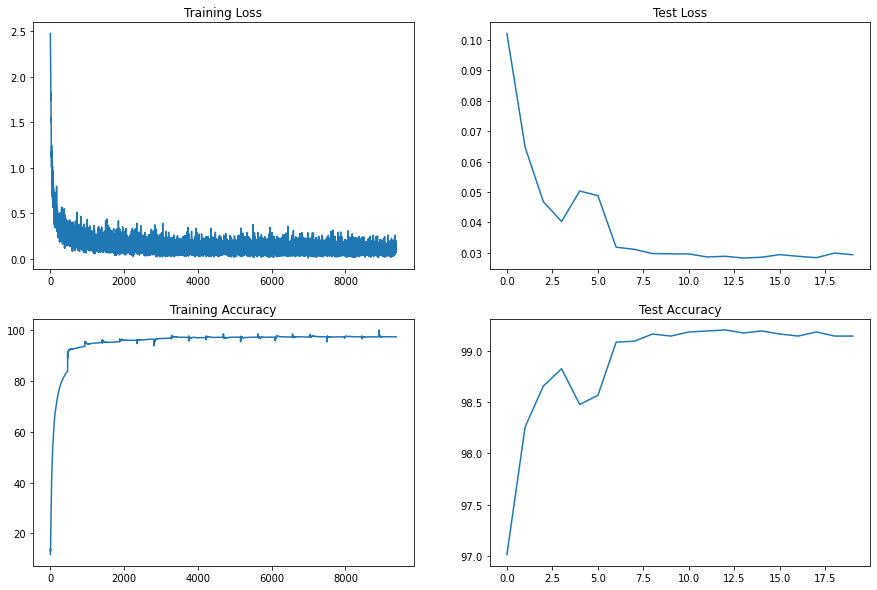

In [28]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [0]:
dropout_value = 0.1
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=13, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.BatchNorm2d(13)
            
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=13, out_channels=13, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.BatchNorm2d(13)
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=13, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.BatchNorm2d(12)
        ) # output_size = 22

        self.convblock31 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.BatchNorm2d(12)
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.BatchNorm2d(12)
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.BatchNorm2d(12)
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.BatchNorm2d(12)
        ) # output_size = 7

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.BatchNorm2d(12)
        ) # output_size = 7

        self.convblock71 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.BatchNorm2d(20)
        ) # output_size = 7

        self.convblock72 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=48, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            nn.BatchNorm2d(48)
        ) # output_size = 7

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5),
            nn.ReLU(),
            nn.BatchNorm2d(48),
            nn.Dropout(dropout_value)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=48, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1


    def forward(self, x):
        x = self.convblock1(x)# 26x26
        x = self.convblock2(x)# 24x24
        x = self.convblock3(x)# 22x22
        x = self.convblock31(x)# 22x22
        x = self.pool1(x) # 11x11

        
        x = self.convblock4(x) # 11x11
        x = self.convblock5(x) # 9x9
        x = self.convblock6(x) # 7x7
        x = self.convblock7(x) # 7x7
        x = self.convblock71(x) # 5x5
        x = self.convblock72(x) # 5x5
        x = self.gap(x)
        x = self.convblock8(x) #1x1
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [0]:
model1 =  Net1().to(device)


loss_function = F.nll_loss
#loss_function = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model1.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 20

In [31]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []


for epoch in range(EPOCHS):
    train(model1, train_loader, optimizer, loss_function, device, epoch, train_losses, train_acc)
    test(model1, test_loader, loss_function, device, test_losses, test_acc)
    scheduler.step()

  0%|          | 0/469 [00:00<?, ?it/s]

Started Epoch 1....



Loss=0.08397295325994492 Batch_id=468 Accuracy=86.99: 100%|██████████| 469/469 [00:15<00:00, 29.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1372, Accuracy: 9595/10000 (96%)

Started Epoch 2....



Loss=0.1792403608560562 Batch_id=468 Accuracy=96.07: 100%|██████████| 469/469 [00:15<00:00, 30.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0819, Accuracy: 9741/10000 (97%)

Started Epoch 3....



Loss=0.07301993668079376 Batch_id=468 Accuracy=96.80: 100%|██████████| 469/469 [00:15<00:00, 29.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1045, Accuracy: 9673/10000 (97%)

Started Epoch 4....



Loss=0.11459225416183472 Batch_id=468 Accuracy=97.26: 100%|██████████| 469/469 [00:15<00:00, 29.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0664, Accuracy: 9796/10000 (98%)

Started Epoch 5....



Loss=0.10431604832410812 Batch_id=468 Accuracy=97.50: 100%|██████████| 469/469 [00:15<00:00, 29.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0559, Accuracy: 9837/10000 (98%)

Started Epoch 6....



Loss=0.07727935165166855 Batch_id=468 Accuracy=97.71: 100%|██████████| 469/469 [00:15<00:00, 29.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0515, Accuracy: 9843/10000 (98%)

Started Epoch 7....



Loss=0.014387759380042553 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:15<00:00, 29.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0449, Accuracy: 9867/10000 (99%)

Started Epoch 8....



Loss=0.04833288863301277 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:15<00:00, 29.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0390, Accuracy: 9887/10000 (99%)

Started Epoch 9....



Loss=0.12645785510540009 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:15<00:00, 29.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0396, Accuracy: 9885/10000 (99%)

Started Epoch 10....



Loss=0.14471356570720673 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:15<00:00, 29.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0407, Accuracy: 9880/10000 (99%)

Started Epoch 11....



Loss=0.09571459144353867 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:15<00:00, 29.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0406, Accuracy: 9877/10000 (99%)

Started Epoch 12....



Loss=0.15348726511001587 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:15<00:00, 29.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0398, Accuracy: 9882/10000 (99%)

Started Epoch 13....



Loss=0.10939683765172958 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:15<00:00, 29.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0417, Accuracy: 9877/10000 (99%)

Started Epoch 14....



Loss=0.08986684679985046 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:15<00:00, 29.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Accuracy: 9880/10000 (99%)

Started Epoch 15....



Loss=0.02314889430999756 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:15<00:00, 29.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0405, Accuracy: 9877/10000 (99%)

Started Epoch 16....



Loss=0.01733306236565113 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:15<00:00, 29.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0422, Accuracy: 9876/10000 (99%)

Started Epoch 17....



Loss=0.029418865218758583 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:15<00:00, 29.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0411, Accuracy: 9876/10000 (99%)

Started Epoch 18....



Loss=0.0326065756380558 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:15<00:00, 29.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0379, Accuracy: 9888/10000 (99%)

Started Epoch 19....



Loss=0.05944370850920677 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:15<00:00, 29.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0388, Accuracy: 9884/10000 (99%)

Started Epoch 20....



Loss=0.051616549491882324 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:15<00:00, 29.66it/s]



Test set: Average loss: 0.0405, Accuracy: 9875/10000 (99%)



Text(0.5, 1.0, 'Test Accuracy')

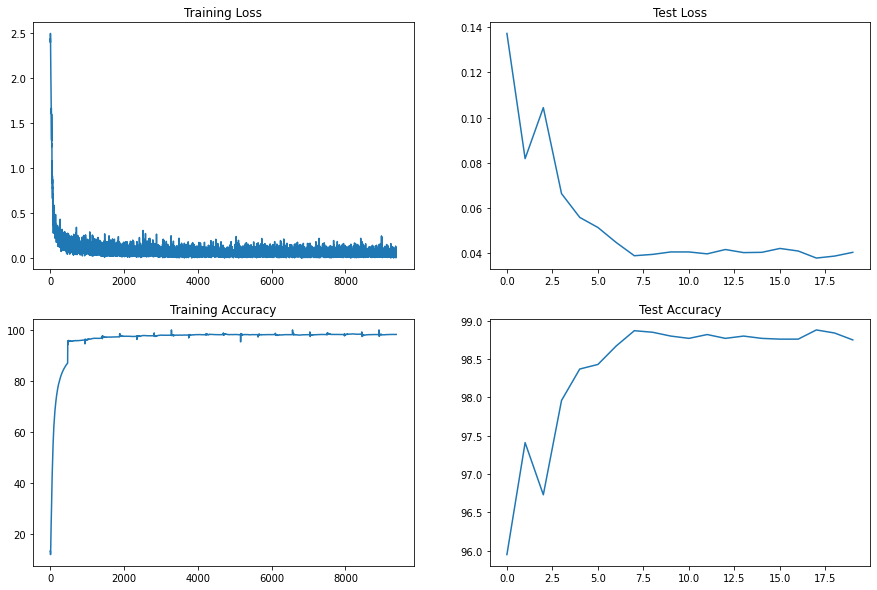

In [32]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [0]:
dropout_value = 0.2

OP_CH_CONV_BLK1  = 16
OP_CH_CONV_BLK2  = 16
OP_CH_CONV_BLK21 = 28
OP_CH_CONV_BLK3  = 14
OP_CH_CONV_BLK4  = 14
OP_CH_CONV_BLK5  = 14
OP_CH_CONV_BLK6  = 13
OP_CH_CONV_BLK7  = 13
OP_CH_CONV_BLK71 = 48
OP_CH_CONV_BLK8  = 20
OP_NODES = 10


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=OP_CH_CONV_BLK1, kernel_size=(3, 3), padding=0, bias=False),
                                        nn.ReLU(),
                                        nn.Dropout(dropout_value),
                                        nn.BatchNorm2d(OP_CH_CONV_BLK1)
                                        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(nn.Conv2d(in_channels=OP_CH_CONV_BLK1, out_channels=OP_CH_CONV_BLK2, kernel_size=(3, 3), padding=0, bias=False),
                                        nn.ReLU(),
                                        nn.Dropout(dropout_value),
                                        nn.BatchNorm2d(OP_CH_CONV_BLK2)
                                        ) # output_size = 24


        self.convblock21 = nn.Sequential(
                                        nn.Conv2d(in_channels=OP_CH_CONV_BLK2, out_channels=OP_CH_CONV_BLK21, kernel_size=(1, 1), padding=0, bias=False),
                                        nn.ReLU(),
                                        nn.Dropout(dropout_value),
                                        nn.BatchNorm2d(OP_CH_CONV_BLK21)
                                        ) # output_size = 22
        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        self.convblock3 = nn.Sequential(
                                        nn.Conv2d(in_channels=OP_CH_CONV_BLK21, out_channels=OP_CH_CONV_BLK3, kernel_size=(3, 3), padding=0, bias=False),
                                        nn.ReLU(),
                                        nn.Dropout(dropout_value),
                                        nn.BatchNorm2d(OP_CH_CONV_BLK3)
                                        ) # output_size = 10


        self.convblock4 = nn.Sequential(
                                        nn.Conv2d(in_channels=OP_CH_CONV_BLK3, out_channels=OP_CH_CONV_BLK4, kernel_size=(1, 1), padding=0, bias=False),
                                        nn.ReLU(),
                                        nn.Dropout(dropout_value),
                                        nn.BatchNorm2d(OP_CH_CONV_BLK4)
                                        ) # output_size = 8


        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
                                        nn.Conv2d(in_channels=OP_CH_CONV_BLK4, out_channels=OP_CH_CONV_BLK5, kernel_size=(3, 3), padding=0, bias=False),
                                        nn.ReLU(),
                                        nn.Dropout(dropout_value),
                                        nn.BatchNorm2d(OP_CH_CONV_BLK5)
                                        ) # output_size = 6

        self.convblock6 = nn.Sequential(
                                        nn.Conv2d(in_channels=OP_CH_CONV_BLK5, out_channels=OP_CH_CONV_BLK6, kernel_size=(3, 3), padding=0, bias=False),
                                        nn.ReLU(),
                                        nn.Dropout(dropout_value),
                                        nn.BatchNorm2d(OP_CH_CONV_BLK6)
                                        ) # output_size = 4

        self.convblock7 = nn.Sequential(
                                          nn.Conv2d(in_channels=OP_CH_CONV_BLK6, out_channels=OP_CH_CONV_BLK7, kernel_size=(3, 3), padding=0, bias=False),
                                          nn.ReLU(),
                                          nn.Dropout(dropout_value),
                                          nn.BatchNorm2d(OP_CH_CONV_BLK7)
                                          ) # output_size = 2

        self.convblock71 = nn.Sequential(
                                          nn.Conv2d(in_channels=OP_CH_CONV_BLK7, out_channels=OP_CH_CONV_BLK71, kernel_size=(1, 1), padding=0, bias=False),
                                          nn.ReLU(),
                                          nn.Dropout(dropout_value),
                                          nn.BatchNorm2d(OP_CH_CONV_BLK71)
                                          ) # output_size = 2
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
                                  nn.AvgPool2d(kernel_size=4),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(OP_CH_CONV_BLK71),
                                  nn.Dropout(dropout_value)
                                  ) # output_size = 1

        self.convblock8 = nn.Sequential(
                                          nn.Conv2d(in_channels=OP_CH_CONV_BLK71, out_channels=OP_CH_CONV_BLK8, kernel_size=(1, 1), padding=0, bias=False),
                                          nn.ReLU(),
                                          nn.Dropout(dropout_value),
                                          nn.BatchNorm2d(OP_CH_CONV_BLK8)
                                          ) # output_size = 2

        self.convblock81 = nn.Sequential(
                                        nn.Conv2d(in_channels=OP_CH_CONV_BLK8, out_channels=OP_NODES, kernel_size=(1, 1), padding=0, bias=False),
                                        # nn.BatchNorm2d(10), NEVER
                                        # nn.ReLU() NEVER!
                                        ) # output_size = 1


    def forward(self, x):
        x = self.convblock1(x)# 26x26
        x = self.convblock2(x)# 24x24
        x = self.convblock21(x)# 24x24
        x = self.pool1(x) # 12x12
        x = self.convblock3(x)# 10x10
        x = self.convblock4(x) # 8x8
        x = self.convblock5(x) # 6x6
        x = self.convblock6(x) # 4x4
        x = self.convblock7(x) # 2x2
        x = self.convblock71(x) # 2x2
        x = self.gap(x)
        x = self.convblock8(x) #1x1
        x = self.convblock81(x) #1x1
        x = x.view(-1, OP_NODES)
        return F.log_softmax(x, dim=-1)

In [46]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

loss_function = F.nll_loss
#loss_function = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=False, threshold=0.0001, threshold_mode='rel', cooldown=2, min_lr=0.0001, eps=1e-08)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
           Dropout-3           [-1, 16, 26, 26]               0
       BatchNorm2d-4           [-1, 16, 26, 26]              32
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
           Dropout-7           [-1, 16, 24, 24]               0
       BatchNorm2d-8           [-1, 16, 24, 24]              32
            Conv2d-9           [-1, 28, 24, 24]             448
             ReLU-10           [-1, 28, 24, 24]               0
          Dropout-11           [-1, 28, 24, 24]               0
      BatchNorm2d-12           [-1, 28, 24, 24]              56
        MaxPool2d-13           [-1, 28, 12, 12]               0
           Conv2d-14           [-1, 14,

In [48]:
EPOCHS = 20

train_losses = []
test_losses = []
train_acc = []
test_acc = []


for epoch in range(EPOCHS):
    train(model, train_loader, optimizer, loss_function, device, epoch, train_losses, train_acc)
    val_loss = test(model, test_loader, loss_function, device, test_losses, test_acc)
    scheduler.step(val_loss)
    print("learning rate: ", scheduler.state_dict)

  0%|          | 0/469 [00:00<?, ?it/s]

Started Epoch 1....



Loss=0.25159183144569397 Batch_id=468 Accuracy=93.72: 100%|██████████| 469/469 [00:15<00:00, 29.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0908, Accuracy: 9738/10000 (97%)

learning rate:  <bound method ReduceLROnPlateau.state_dict of <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7f0765784f98>>
Started Epoch 2....



Loss=0.3177967071533203 Batch_id=468 Accuracy=95.04: 100%|██████████| 469/469 [00:15<00:00, 29.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0737, Accuracy: 9782/10000 (98%)

learning rate:  <bound method ReduceLROnPlateau.state_dict of <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7f0765784f98>>
Started Epoch 3....



Loss=0.2316851019859314 Batch_id=468 Accuracy=95.75: 100%|██████████| 469/469 [00:15<00:00, 29.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0935, Accuracy: 9738/10000 (97%)

learning rate:  <bound method ReduceLROnPlateau.state_dict of <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7f0765784f98>>
Started Epoch 4....



Loss=0.08861875534057617 Batch_id=468 Accuracy=96.15: 100%|██████████| 469/469 [00:15<00:00, 29.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0599, Accuracy: 9826/10000 (98%)

learning rate:  <bound method ReduceLROnPlateau.state_dict of <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7f0765784f98>>
Started Epoch 5....



Loss=0.10353276133537292 Batch_id=468 Accuracy=96.49: 100%|██████████| 469/469 [00:16<00:00, 28.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0498, Accuracy: 9857/10000 (99%)

learning rate:  <bound method ReduceLROnPlateau.state_dict of <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7f0765784f98>>
Started Epoch 6....



Loss=0.07501441985368729 Batch_id=468 Accuracy=96.67: 100%|██████████| 469/469 [00:16<00:00, 29.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0525, Accuracy: 9847/10000 (98%)

learning rate:  <bound method ReduceLROnPlateau.state_dict of <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7f0765784f98>>
Started Epoch 7....



Loss=0.08724824339151382 Batch_id=468 Accuracy=96.81: 100%|██████████| 469/469 [00:15<00:00, 29.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0474, Accuracy: 9862/10000 (99%)

learning rate:  <bound method ReduceLROnPlateau.state_dict of <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7f0765784f98>>
Started Epoch 8....



Loss=0.12796340882778168 Batch_id=468 Accuracy=96.94: 100%|██████████| 469/469 [00:16<00:00, 29.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0398, Accuracy: 9881/10000 (99%)

learning rate:  <bound method ReduceLROnPlateau.state_dict of <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7f0765784f98>>
Started Epoch 9....



Loss=0.18563587963581085 Batch_id=468 Accuracy=97.04: 100%|██████████| 469/469 [00:15<00:00, 29.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0414, Accuracy: 9876/10000 (99%)

learning rate:  <bound method ReduceLROnPlateau.state_dict of <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7f0765784f98>>
Started Epoch 10....



Loss=0.06231841444969177 Batch_id=468 Accuracy=97.04: 100%|██████████| 469/469 [00:15<00:00, 29.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0451, Accuracy: 9867/10000 (99%)

learning rate:  <bound method ReduceLROnPlateau.state_dict of <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7f0765784f98>>
Started Epoch 11....



Loss=0.11075825244188309 Batch_id=468 Accuracy=97.07: 100%|██████████| 469/469 [00:16<00:00, 29.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0391, Accuracy: 9889/10000 (99%)

learning rate:  <bound method ReduceLROnPlateau.state_dict of <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7f0765784f98>>
Started Epoch 12....



Loss=0.17516227066516876 Batch_id=468 Accuracy=97.27: 100%|██████████| 469/469 [00:15<00:00, 29.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0477, Accuracy: 9867/10000 (99%)

learning rate:  <bound method ReduceLROnPlateau.state_dict of <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7f0765784f98>>
Started Epoch 13....



Loss=0.08471080660820007 Batch_id=468 Accuracy=97.26: 100%|██████████| 469/469 [00:16<00:00, 29.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0447, Accuracy: 9871/10000 (99%)

learning rate:  <bound method ReduceLROnPlateau.state_dict of <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7f0765784f98>>
Started Epoch 14....



Loss=0.060636814683675766 Batch_id=468 Accuracy=97.33: 100%|██████████| 469/469 [00:15<00:00, 29.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0448, Accuracy: 9877/10000 (99%)

learning rate:  <bound method ReduceLROnPlateau.state_dict of <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7f0765784f98>>
Started Epoch 15....



Loss=0.03312065452337265 Batch_id=468 Accuracy=97.29: 100%|██████████| 469/469 [00:16<00:00, 29.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0446, Accuracy: 9876/10000 (99%)

learning rate:  <bound method ReduceLROnPlateau.state_dict of <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7f0765784f98>>
Started Epoch 16....



Loss=0.07446622103452682 Batch_id=468 Accuracy=97.58: 100%|██████████| 469/469 [00:16<00:00, 29.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0392, Accuracy: 9892/10000 (99%)

learning rate:  <bound method ReduceLROnPlateau.state_dict of <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7f0765784f98>>
Started Epoch 17....



Loss=0.046469252556562424 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:16<00:00, 29.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0371, Accuracy: 9902/10000 (99%)

learning rate:  <bound method ReduceLROnPlateau.state_dict of <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7f0765784f98>>
Started Epoch 18....



Loss=0.031122395768761635 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:15<00:00, 29.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0372, Accuracy: 9895/10000 (99%)

learning rate:  <bound method ReduceLROnPlateau.state_dict of <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7f0765784f98>>
Started Epoch 19....



Loss=0.10653328895568848 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:16<00:00, 29.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Accuracy: 9910/10000 (99%)

learning rate:  <bound method ReduceLROnPlateau.state_dict of <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7f0765784f98>>
Started Epoch 20....



Loss=0.07655271887779236 Batch_id=468 Accuracy=97.71: 100%|██████████| 469/469 [00:16<00:00, 29.04it/s]



Test set: Average loss: 0.0316, Accuracy: 9915/10000 (99%)

learning rate:  <bound method ReduceLROnPlateau.state_dict of <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7f0765784f98>>


In [38]:
print("learning rate: ", scheduler.get_last_lr())

learning rate:  [1e-05]


In [0]:
#dropout_value = 0.2

OP_CH_CONV_BLK1  = 32
OP_CH_CONV_BLK2  = 32
OP_CH_CONV_BLK3  = 32
OP_CH_CONV_BLK4  = 32
OP_CH_CONV_BLK5  = 64
OP_CH_CONV_BLK6  = 20
OP_NODES = 10


class Net(nn.Module):
    def __init__(self, dropout_value):
        super(Net, self).__init__()
        self.__dropout_value = dropout_value
        # Input Block
        self.convblock1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=OP_CH_CONV_BLK1, kernel_size=(3, 3), padding=0, bias=False),
                                        nn.ReLU(),
                                        nn.Dropout(self.__dropout_value),
                                        nn.BatchNorm2d(OP_CH_CONV_BLK1)
                                        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(nn.Conv2d(in_channels=OP_CH_CONV_BLK1, out_channels=OP_CH_CONV_BLK2, kernel_size=(3, 3), padding=0, bias=False),
                                        nn.ReLU(),
                                        nn.Dropout(self.__dropout_value),
                                        nn.BatchNorm2d(OP_CH_CONV_BLK2)
                                        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        self.convblock3 = nn.Sequential(
                                        nn.Conv2d(in_channels=OP_CH_CONV_BLK2, out_channels=OP_CH_CONV_BLK3, kernel_size=(3, 3), padding=0, bias=False),
                                        nn.ReLU(),
                                        nn.Dropout(self.__dropout_value),
                                        nn.BatchNorm2d(OP_CH_CONV_BLK3)
                                        ) # output_size = 10

        self.convblock4 = nn.Sequential(
                                        nn.Conv2d(in_channels=OP_CH_CONV_BLK3, out_channels=OP_CH_CONV_BLK4, kernel_size=(3, 3), padding=0, bias=False),
                                        nn.ReLU(),
                                        nn.Dropout(self.__dropout_value),
                                        nn.BatchNorm2d(OP_CH_CONV_BLK4)
                                        ) # output_size = 8

        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 4

        self.convblock5 = nn.Sequential(
                                        nn.Conv2d(in_channels=OP_CH_CONV_BLK4, out_channels=OP_CH_CONV_BLK5, kernel_size=(1, 1), padding=0, bias=False),
                                        nn.ReLU(),
                                        nn.Dropout(self.__dropout_value),
                                        nn.BatchNorm2d(OP_CH_CONV_BLK5)
                                        ) # output_size = 4

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
                                  nn.AvgPool2d(kernel_size=4),
                                  nn.ReLU(),
                                  nn.Dropout(self.__dropout_value),
                                  nn.BatchNorm2d(OP_CH_CONV_BLK5)
                                  ) # output_size = 1

        self.convblock6 = nn.Sequential(
                                          nn.Conv2d(in_channels=OP_CH_CONV_BLK5, out_channels=OP_CH_CONV_BLK6, kernel_size=(1, 1), padding=0, bias=False),
                                          nn.ReLU(),
                                          nn.Dropout(self.__dropout_value),
                                          nn.BatchNorm2d(OP_CH_CONV_BLK6)
                                          ) # output_size = 1

        self.convblock7 = nn.Sequential(
                                        nn.Conv2d(in_channels=OP_CH_CONV_BLK6, out_channels=OP_NODES, kernel_size=(1, 1), padding=0, bias=False),
                                        # nn.BatchNorm2d(10), NEVER
                                        # nn.ReLU() NEVER!
                                        ) # output_size = 1


    def forward(self, x):
        x = self.convblock1(x)# 26x26
        x = self.convblock2(x)# 24x24
        x = self.pool1(x) # 12x12
        x = self.convblock3(x)# 10x10
        x = self.convblock4(x) # 8x8
        x = self.pool1(x) # 4x4
        x = self.convblock5(x) #1x1
        x = self.gap(x)
        x = self.convblock6(x) #1x1
        x = self.convblock7(x) #1x1
        x = x.view(-1, OP_NODES)
        return F.log_softmax(x, dim=-1)

In [79]:
model = Net(0.25).to(device)
summary(model, input_size=(1, 28, 28))

loss_function = F.nll_loss
#loss_function = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True, threshold=0.001, threshold_mode='rel', cooldown=2, min_lr=0.0001, eps=1e-08)
scheduler = StepLR(optimizer, step_size=9, gamma=0.1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             288
              ReLU-2           [-1, 32, 26, 26]               0
           Dropout-3           [-1, 32, 26, 26]               0
       BatchNorm2d-4           [-1, 32, 26, 26]              64
            Conv2d-5           [-1, 32, 24, 24]           9,216
              ReLU-6           [-1, 32, 24, 24]               0
           Dropout-7           [-1, 32, 24, 24]               0
       BatchNorm2d-8           [-1, 32, 24, 24]              64
         MaxPool2d-9           [-1, 32, 12, 12]               0
           Conv2d-10           [-1, 32, 10, 10]           9,216
             ReLU-11           [-1, 32, 10, 10]               0
          Dropout-12           [-1, 32, 10, 10]               0
      BatchNorm2d-13           [-1, 32, 10, 10]              64
           Conv2d-14             [-1, 3

In [80]:
EPOCHS = 20

train_losses = []
test_losses = []
train_acc = []
test_acc = []


for epoch in range(EPOCHS):
    train(model, train_loader, optimizer, loss_function, device, epoch, train_losses, train_acc)
    val_loss = test(model, test_loader, loss_function, device, test_losses, test_acc)
    if scheduler:
      scheduler.step()
      print("learning rate: ", scheduler.optimizer.param_groups[0]['lr'])

  0%|          | 0/469 [00:00<?, ?it/s]

Started Epoch 1....



Loss=0.35033515095710754 Batch_id=468 Accuracy=73.54: 100%|██████████| 469/469 [00:14<00:00, 33.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2307, Accuracy: 9492/10000 (95%)

learning rate:  0.01
Started Epoch 2....



Loss=0.18101860582828522 Batch_id=468 Accuracy=91.27: 100%|██████████| 469/469 [00:14<00:00, 33.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1216, Accuracy: 9675/10000 (97%)

learning rate:  0.01
Started Epoch 3....



Loss=0.09340337663888931 Batch_id=468 Accuracy=93.63: 100%|██████████| 469/469 [00:14<00:00, 33.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0972, Accuracy: 9746/10000 (97%)

learning rate:  0.01
Started Epoch 4....



Loss=0.11806535720825195 Batch_id=468 Accuracy=94.46: 100%|██████████| 469/469 [00:14<00:00, 33.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0797, Accuracy: 9753/10000 (98%)

learning rate:  0.01
Started Epoch 5....



Loss=0.12170352786779404 Batch_id=468 Accuracy=95.13: 100%|██████████| 469/469 [00:14<00:00, 32.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0692, Accuracy: 9794/10000 (98%)

learning rate:  0.01
Started Epoch 6....



Loss=0.19079804420471191 Batch_id=468 Accuracy=95.45: 100%|██████████| 469/469 [00:13<00:00, 33.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0598, Accuracy: 9833/10000 (98%)

learning rate:  0.01
Started Epoch 7....



Loss=0.16083838045597076 Batch_id=468 Accuracy=95.65: 100%|██████████| 469/469 [00:14<00:00, 33.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0585, Accuracy: 9809/10000 (98%)

learning rate:  0.01
Started Epoch 8....



Loss=0.19923163950443268 Batch_id=468 Accuracy=95.94: 100%|██████████| 469/469 [00:13<00:00, 33.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0569, Accuracy: 9822/10000 (98%)

learning rate:  0.01
Started Epoch 9....



Loss=0.10580015927553177 Batch_id=468 Accuracy=96.19: 100%|██████████| 469/469 [00:13<00:00, 33.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0535, Accuracy: 9841/10000 (98%)

learning rate:  0.001
Started Epoch 10....



Loss=0.2419385313987732 Batch_id=468 Accuracy=96.66: 100%|██████████| 469/469 [00:14<00:00, 33.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0477, Accuracy: 9863/10000 (99%)

learning rate:  0.001
Started Epoch 11....



Loss=0.07635746151208878 Batch_id=468 Accuracy=96.79: 100%|██████████| 469/469 [00:13<00:00, 34.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0484, Accuracy: 9860/10000 (99%)

learning rate:  0.001
Started Epoch 12....



Loss=0.08252996951341629 Batch_id=468 Accuracy=96.65: 100%|██████████| 469/469 [00:13<00:00, 33.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0492, Accuracy: 9851/10000 (99%)

learning rate:  0.001
Started Epoch 13....



Loss=0.07842335850000381 Batch_id=468 Accuracy=96.70: 100%|██████████| 469/469 [00:13<00:00, 33.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0449, Accuracy: 9862/10000 (99%)

learning rate:  0.001
Started Epoch 14....



Loss=0.08650263398885727 Batch_id=468 Accuracy=97.02: 100%|██████████| 469/469 [00:13<00:00, 33.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0468, Accuracy: 9866/10000 (99%)

learning rate:  0.001
Started Epoch 15....



Loss=0.17363731563091278 Batch_id=468 Accuracy=96.78: 100%|██████████| 469/469 [00:14<00:00, 33.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0449, Accuracy: 9865/10000 (99%)

learning rate:  0.001
Started Epoch 16....



Loss=0.1559557169675827 Batch_id=468 Accuracy=96.93: 100%|██████████| 469/469 [00:13<00:00, 33.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0432, Accuracy: 9869/10000 (99%)

learning rate:  0.001
Started Epoch 17....



Loss=0.11516895890235901 Batch_id=468 Accuracy=97.04: 100%|██████████| 469/469 [00:13<00:00, 33.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0446, Accuracy: 9869/10000 (99%)

learning rate:  0.001
Started Epoch 18....



Loss=0.11221761256456375 Batch_id=468 Accuracy=96.98: 100%|██████████| 469/469 [00:13<00:00, 33.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0461, Accuracy: 9857/10000 (99%)

learning rate:  0.0001
Started Epoch 19....



Loss=0.22004854679107666 Batch_id=468 Accuracy=97.04: 100%|██████████| 469/469 [00:13<00:00, 33.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0410, Accuracy: 9873/10000 (99%)

learning rate:  0.0001
Started Epoch 20....



Loss=0.13677234947681427 Batch_id=468 Accuracy=97.00: 100%|██████████| 469/469 [00:13<00:00, 34.03it/s]



Test set: Average loss: 0.0437, Accuracy: 9868/10000 (99%)

learning rate:  0.0001
